In [1]:

import uproot
import numpy as np
import mplhep as hep
import dask_awkward as dk
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import vector
import random
import time 
import hist
from uncertainties import unumpy as unp
import os

In [27]:
import uproot
import os

# -----------------------------
# Load POWHEG NanoAOD samples (truth level)
# -----------------------------
directory_path_nanoaod = "/depot/cms/top/bhanda25/EFT/Nanoaod_powheg/"

# Automatically find all .root files in the directory
desired_files_powheg = [
    f for f in os.listdir(directory_path_nanoaod)
    if f.endswith(".root")
]

# Build full paths
file_paths_powheg = [os.path.join(directory_path_nanoaod, f) for f in desired_files_powheg]

# Load the "Events" tree from each file
trees_powheg = [uproot.open(fp)["Events"] for fp in file_paths_powheg]

# Concatenate all trees into one
nanogen = uproot.concatenate(trees_powheg)


In [28]:
nanogen

<Array [{run: 1, ...}, ..., {run: 1, ...}] type='400000 * {run: uint32, lum...'>

In [29]:
genpart_pt = nanogen['GenPart_pt']
genpart_eta = nanogen['GenPart_eta']
genpart_phi = nanogen['GenPart_phi']
genpart_mass = nanogen['GenPart_mass']
genpart_pid = nanogen['GenPart_pdgId']
genpart_mother = nanogen['GenPart_genPartIdxMother']
gen_weight=nanogen['LHEReweightingWeight']

In [30]:

genvec = vector.Array(ak.zip({
    "pt": genpart_pt,
    "eta": genpart_eta,
    "phi": genpart_phi,
    "mass": genpart_mass,
}))

# Extract vector components
E = genvec.E
px = genvec.px
py = genvec.py
pz = genvec.pz

In [31]:
# Identify particle masks
is_top = genpart_pid == 6
is_antitop = genpart_pid == -6
is_wplus = genpart_pid == 24
is_wminus = genpart_pid == -24
is_bottom = genpart_pid == 5
is_antibottom = genpart_pid == -5

# Get local indices
indices = ak.local_index(genpart_pid)

# Get top and antitop indices
top_indices = indices[is_top]
antitop_indices = indices[is_antitop]

# Get W+ and W- mother indices
wplus_mothers = genpart_mother[is_wplus]
wminus_mothers = genpart_mother[is_wminus]

# Match top → W+ and antitop → W-
top_with_wplus_daughter_mask = ak.any(top_indices[:, :, None] == wplus_mothers[:, None, :], axis=-1)
antitop_with_wminus_daughter_mask = ak.any(antitop_indices[:, :, None] == wminus_mothers[:, None, :], axis=-1)

# Now find W+ and W- indices
Wplus_indices = indices[is_wplus]
Wminus_indices = indices[is_wminus]

# Step 3: For each particle, check if its mother is a W⁺ or W⁻ (element-wise)
mother_is_Wplus = ak.any(genpart_mother[:, None] == Wplus_indices, axis=1)
mother_is_Wminus = ak.any(genpart_mother[:, None] == Wminus_indices, axis=1)

# Require both decays
has_two_tops = (ak.sum(top_with_wplus_daughter_mask, axis=1) +
                ak.sum(antitop_with_wminus_daughter_mask, axis=1)) == 2


In [32]:
def compute_gen_spin_corrs(E, px, py, pz, is_top, is_antitop, dilepton_event_mask,
                           top_with_wplus_daughter_mask, antitop_with_wminus_daughter_mask,
                           mother_is_Wplus, mother_is_Wminus, 
                           Wplus_daughter_mask, Wminus_daughter_mask):
    
    
    # Extract masked jagged arrays
    top_E  = E[is_top][top_with_wplus_daughter_mask][dilepton_event_mask]
    top_px = px[is_top][top_with_wplus_daughter_mask][dilepton_event_mask]
    top_py = py[is_top][top_with_wplus_daughter_mask][dilepton_event_mask]
    top_pz = pz[is_top][top_with_wplus_daughter_mask][dilepton_event_mask]

    tbar_E  = E[is_antitop][antitop_with_wminus_daughter_mask][dilepton_event_mask]
    tbar_px = px[is_antitop][antitop_with_wminus_daughter_mask][dilepton_event_mask]
    tbar_py = py[is_antitop][antitop_with_wminus_daughter_mask][dilepton_event_mask]
    tbar_pz = pz[is_antitop][antitop_with_wminus_daughter_mask][dilepton_event_mask]

    l_E  = E[mother_is_Wminus][Wminus_daughter_mask][dilepton_event_mask]
    l_px = px[mother_is_Wminus][Wminus_daughter_mask][dilepton_event_mask]
    l_py = py[mother_is_Wminus][Wminus_daughter_mask][dilepton_event_mask]
    l_pz = pz[mother_is_Wminus][Wminus_daughter_mask][dilepton_event_mask]

    lbar_E  = E[mother_is_Wplus][Wplus_daughter_mask][dilepton_event_mask]
    lbar_px = px[mother_is_Wplus][Wplus_daughter_mask][dilepton_event_mask]
    lbar_py = py[mother_is_Wplus][Wplus_daughter_mask][dilepton_event_mask]
    lbar_pz = pz[mother_is_Wplus][Wplus_daughter_mask][dilepton_event_mask]

    # Build valid event mask: events where all branches have length == 1
    valid_events = (
        (ak.num(top_E) == 1) &
        (ak.num(tbar_E) == 1) &
        (ak.num(l_E) == 1) &
        (ak.num(lbar_E) == 1)
    )

    # Apply valid event mask (still keeping jagged structure, shape = [N][1])
    top_E = top_E[valid_events]
    top_px = top_px[valid_events]
    top_py = top_py[valid_events]
    top_pz = top_pz[valid_events]

    tbar_E = tbar_E[valid_events]
    tbar_px = tbar_px[valid_events]
    tbar_py = tbar_py[valid_events]
    tbar_pz = tbar_pz[valid_events]

    l_E = l_E[valid_events]
    l_px = l_px[valid_events]
    l_py = l_py[valid_events]
    l_pz = l_pz[valid_events]

    lbar_E = lbar_E[valid_events]
    lbar_px = lbar_px[valid_events]
    lbar_py = lbar_py[valid_events]
    lbar_pz = lbar_pz[valid_events]

    # Build 4-vectors from consistent [N][1] arrays
    tops = vector.zip({'E': top_E, 'px': top_px, 'py': top_py, 'pz': top_pz})
    tbars = vector.zip({'E': tbar_E, 'px': tbar_px, 'py': tbar_py, 'pz': tbar_pz})
    ls = vector.zip({'E': l_E, 'px': l_px, 'py': l_py, 'pz': l_pz})
    lbars = vector.zip({'E': lbar_E, 'px': lbar_px, 'py': lbar_py, 'pz': lbar_pz})
    
    

    # Compute spin correlation observables in one step
    ttbar_frame = tops + tbars
    boosted_tops = tops.boostCM_of(ttbar_frame)
    boosted_tbars = tbars.boostCM_of(ttbar_frame)
    boosted_ls = ls.boostCM_of(ttbar_frame).boostCM_of(boosted_tbars)
    boosted_lbars = lbars.boostCM_of(ttbar_frame).boostCM_of(boosted_tops)
    p_axis = vector.obj(x=0, y=0, z=1)
    k_axis = boosted_tops.to_xyz().unit()
    scattering_angle = k_axis.theta
    sin_scat_angle = np.sin(scattering_angle)
    sin_scat_angle = np.where(np.abs(sin_scat_angle) < 1e-5, 1e-5, sin_scat_angle)
    axis_coeff = np.sign(np.cos(scattering_angle)) / np.abs(sin_scat_angle)
    r_axis = axis_coeff * (p_axis - (k_axis * np.cos(scattering_angle)))
    n_axis = axis_coeff * p_axis.cross(k_axis)
    
    ll_cHel = np.cos(boosted_lbars.deltaangle(boosted_ls).to_numpy()).reshape(-1)
    cos_theta1k = np.cos(boosted_lbars.deltaangle(k_axis).to_numpy())
    cos_theta1r = np.cos(boosted_lbars.deltaangle(r_axis).to_numpy())
    cos_theta1n = np.cos(boosted_lbars.deltaangle(n_axis).to_numpy())
    cos_theta2k = np.cos(boosted_ls.deltaangle(-1 * k_axis).to_numpy())
    cos_theta2r = np.cos(boosted_ls.deltaangle(-1 * r_axis).to_numpy())
    cos_theta2n = np.cos(boosted_ls.deltaangle(-1 * n_axis).to_numpy())
    
    ttbar_mass = (tops + tbars).M.to_numpy().reshape(-1)
    scattering_angle = scattering_angle.to_numpy().reshape(-1)
    B1 = np.stack((cos_theta1k, cos_theta1r, cos_theta1n), axis=1)
    B2 = np.stack((cos_theta2k, cos_theta2r, cos_theta2n), axis=1)
    # Compute individual C_ij components
    c_kk = cos_theta1k * cos_theta2k
    c_kr = cos_theta1k * cos_theta2r
    c_kn = cos_theta1k * cos_theta2n
    c_rk = cos_theta1r * cos_theta2k
    c_rr = cos_theta1r * cos_theta2r
    c_rn = cos_theta1r * cos_theta2n
    c_nk = cos_theta1n * cos_theta2k
    c_nr = cos_theta1n * cos_theta2r
    c_nn = cos_theta1n * cos_theta2n
    
    # Stack them row-wise first, then column-wise, then transpose
    C = np.stack([
        np.stack([c_kk, c_kr, c_kn], axis=1),  # shape (n_events, 3)
        np.stack([c_rk, c_rr, c_rn], axis=1),
        np.stack([c_nk, c_nr, c_nn], axis=1)
    ], axis=1)  # shape will now be (n_events, 3, 3)
    
    return scattering_angle, ttbar_mass, B1, B2, C, ll_cHel, ls, lbars, tops, tbars, valid_events


    

In [33]:
import os
import uproot
import awkward as ak

# Output directory
output_dir = "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen"
os.makedirs(output_dir, exist_ok=True)

# Channel configurations
channel_pdg_ids = {
    "ee": [[-11, 11]],
    "emu": [[-11, 13], [-13, 11]],
    "mumu": [[-13, 13]],
}
channels = list(channel_pdg_ids.keys())

# Loop over channels
for channel in channels:
    # Initialize storage
    dilepton_scat_angle = []
    dilepton_ttbar_mass = []
    dilepton_B1 = np.empty((0, 3))
    dilepton_B2 = np.empty((0, 3))
    dilepton_C = np.empty((0, 3, 3))
    dilepton_ll_cHel = []

    dilepton_l_pt = []
    dilepton_l_eta = []
    dilepton_l_phi = []
    dilepton_l_mass = []

    dilepton_lbar_pt = []
    dilepton_lbar_eta = []
    dilepton_lbar_phi = []
    dilepton_lbar_mass = []

    dilepton_top_pt = []
    dilepton_top_eta = []
    dilepton_top_phi = []
    dilepton_top_mass = []

    dilepton_tbar_pt = []
    dilepton_tbar_eta = []
    dilepton_tbar_phi = []
    dilepton_tbar_mass = []

    # Loop over PDG ID pairs (e.g. [-11, 13] and [-13, 11] for emu)
    for pdg_ids in channel_pdg_ids[channel]:
        Wplus_with_lbar_daughters_mask = genpart_pid[mother_is_Wplus] == pdg_ids[0]
        Wminus_with_l_daughters_mask = genpart_pid[mother_is_Wminus] == pdg_ids[1]

        has_two_leptons = (
            ak.sum(Wplus_with_lbar_daughters_mask, axis=1) +
            ak.sum(Wminus_with_l_daughters_mask, axis=1)
        ) == 2

        dilepton_event_mask = has_two_tops & has_two_leptons

        # Compute observables
        scat_angle, ttbar_mass, B1, B2, C, ll_cHel, l, lbar, top, tbar,valid_events = compute_gen_spin_corrs(
            E, px, py, pz, is_top, is_antitop, dilepton_event_mask,
            top_with_wplus_daughter_mask, antitop_with_wminus_daughter_mask, mother_is_Wplus, mother_is_Wminus,
            Wplus_with_lbar_daughters_mask, Wminus_with_l_daughters_mask)
        
        event_weights=gen_weight[dilepton_event_mask][valid_events]
        if len(dilepton_scat_angle) == 0:
            dilepton_scat_angle = scat_angle
            dilepton_ttbar_mass = ttbar_mass
            dilepton_B1 = B1
            dilepton_B2 = B2
            dilepton_C = C
            dilepton_ll_cHel = ll_cHel
            dilepton_l_pt = l.pt
            dilepton_l_eta = l.eta
            dilepton_l_phi = l.phi
            dilepton_l_mass = l.M
            dilepton_lbar_pt = lbar.pt
            dilepton_lbar_eta = lbar.eta
            dilepton_lbar_phi = lbar.phi
            dilepton_lbar_mass = lbar.M
            dilepton_top_pt = top.pt
            dilepton_top_eta = top.eta
            dilepton_top_phi = top.phi
            dilepton_top_mass = top.M
            dilepton_tbar_pt = tbar.pt
            dilepton_tbar_eta = tbar.eta
            dilepton_tbar_phi = tbar.phi
            dilepton_tbar_mass = tbar.M
            event_weight=event_weights
        else:
            dilepton_scat_angle = np.concatenate((dilepton_scat_angle, scat_angle))
            dilepton_ttbar_mass = np.concatenate((dilepton_ttbar_mass, ttbar_mass))
            dilepton_B1 = np.concatenate((dilepton_B1, B1))
            dilepton_B2 = np.concatenate((dilepton_B2, B2))
            dilepton_C = np.concatenate((dilepton_C, C))
            dilepton_ll_cHel = np.concatenate((dilepton_ll_cHel, ll_cHel))
            dilepton_l_pt = np.concatenate((dilepton_l_pt, l.pt))
            dilepton_l_eta = np.concatenate((dilepton_l_eta, l.eta))
            dilepton_l_phi = np.concatenate((dilepton_l_phi, l.phi))
            dilepton_l_mass = np.concatenate((dilepton_l_mass, l.M))
            dilepton_lbar_pt = np.concatenate((dilepton_lbar_pt, lbar.pt))
            dilepton_lbar_eta = np.concatenate((dilepton_lbar_eta, lbar.eta))
            dilepton_lbar_phi = np.concatenate((dilepton_lbar_phi, lbar.phi))
            dilepton_lbar_mass = np.concatenate((dilepton_lbar_mass, lbar.M))
            dilepton_top_pt = np.concatenate((dilepton_top_pt, top.pt))
            dilepton_top_eta = np.concatenate((dilepton_top_eta, top.eta))
            dilepton_top_phi = np.concatenate((dilepton_top_phi, top.phi))
            dilepton_top_mass = np.concatenate((dilepton_top_mass, top.M))
            dilepton_tbar_pt = np.concatenate((dilepton_tbar_pt, tbar.pt))
            dilepton_tbar_eta = np.concatenate((dilepton_tbar_eta, tbar.eta))
            dilepton_tbar_phi = np.concatenate((dilepton_tbar_phi, tbar.phi))
            dilepton_tbar_mass = np.concatenate((dilepton_tbar_mass, tbar.M))
            event_weight = np.concatenate((event_weight, event_weights))

    # Write output ROOT file per channel
    filename = f"{channel}_nanogen_powheg_ttbar_dileptonic.root"
    branches = [
        dilepton_scat_angle, dilepton_ttbar_mass, dilepton_B1, dilepton_B2, dilepton_C, dilepton_ll_cHel,
        dilepton_l_pt, dilepton_l_eta, dilepton_lbar_pt, dilepton_lbar_eta, dilepton_top_pt, dilepton_top_eta, dilepton_top_phi, dilepton_top_mass,
        dilepton_tbar_pt, dilepton_tbar_eta, dilepton_tbar_phi, dilepton_tbar_mass,event_weight
    ]
    branch_names = [
        "gen_scat_angle", "gen_ttbar_mass", "gen_hel_B1", "gen_hel_B2", "gen_hel_C", "gen_ll_cHel",
        "gen_l_pt", "gen_l_eta", "gen_lbar_pt", "gen_lbar_eta","gen_top_pt", "gen_top_eta", "gen_top_phi", "gen_top_mass", "gen_tbar_pt", 
        "gen_tbar_eta", "gen_tbar_phi", "gen_tbar_mass", "event_weight"  ]

    with uproot.recreate(f"{output_dir}/{filename}") as file:
        for name, branch in zip(branch_names, branches):
            file[name] = ak.Array(branch)

    print(f"✅ {channel} channel written to: {output_dir}/{filename}")


✅ ee channel written to: /depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/ee_nanogen_powheg_ttbar_dileptonic.root
✅ emu channel written to: /depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/emu_nanogen_powheg_ttbar_dileptonic.root
✅ mumu channel written to: /depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/mumu_nanogen_powheg_ttbar_dileptonic.root


In [34]:
import uproot
import awkward as ak

# Input ROOT files
files = [
    "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/ee_nanogen_powheg_ttbar_dileptonic.root",
    "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/emu_nanogen_powheg_ttbar_dileptonic.root",
    "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Output_root_nanogen/mumu_nanogen_powheg_ttbar_dileptonic.root"
]

# Dictionary to hold combined arrays
combined_data = {}

for file_path in files:
    with uproot.open(file_path) as f:
        for tree_name in f.keys():
            clean_key = tree_name.split(";")[0]
            tree = f[tree_name]
            arr = tree.arrays()
            # Each tree has only one field: "", so extract its content
            flat_array = arr[""]
            if clean_key not in combined_data:
                combined_data[clean_key] = [flat_array]
            else:
                combined_data[clean_key].append(flat_array)

# Final merge
combined_data = {k: ak.concatenate(v) for k, v in combined_data.items()}

# Done!
print(f"✅ Combined {len(combined_data)} variables with {len(combined_data['gen_ttbar_mass'])} total events.")


✅ Combined 19 variables with 177450 total events.


In [35]:
combined_data

{'gen_scat_angle': <Array [2.41, 0.738, 0.675, ..., 2.06, 0.609, 1.41] type='177450 * float32'>,
 'gen_ttbar_mass': <Array [373, 372, 396, 502, ..., 359, 360, 665, 403] type='177450 * float32'>,
 'gen_hel_B1': <Array [[[-0.686], ..., [-0.0417]], ..., [...]] type='177450 * 3 * 1 * float64'>,
 'gen_hel_B2': <Array [[[0.901], [0.429], [0.0599]], ...] type='177450 * 3 * 1 * float64'>,
 'gen_hel_C': <Array [[[[-0.619], ..., [-0.0411]], ...], ...] type='177450 * 3 * 3 * 1 * ...'>,
 'gen_ll_cHel': <Array [0.932, -0.759, -0.41, ..., 0.156, -0.383] type='177450 * float32'>,
 'gen_l_pt': <Array [[43.6], [34.9], ..., [53], [89.8]] type='177450 * var * float32'>,
 'gen_l_eta': <Array [[1.49], [-1.02], ..., [-1.72], [-0.637]] type='177450 * var * float32'>,
 'gen_lbar_pt': <Array [[15.3], [35.6], ..., [14.5], [13.7]] type='177450 * var * float32'>,
 'gen_lbar_eta': <Array [[1.68], [0.0806], ..., [-1.17], [1.83]] type='177450 * var * float32'>,
 'gen_top_pt': <Array [[43.2], [36.6], ..., [190], [84.

In [14]:
directory_path_jason = '/eos/purdue/store/user/jthieman/'
desired_files_jason = [
    f"2016preVFP/spinCorrInput_2016preVFP_January2023/Nominal/{flavor}/{flavor}_ttbarsignalplustau_fromDilepton_2016ULpreVFP_{i}.root"
    for flavor in ['ee', 'emu', 'mumu'] for i in range(1)
]
file_paths_jason = [os.path.join(directory_path_jason, f) for f in desired_files_jason]
trees_jason = [uproot.open(fp)['ttBar_treeVariables_step0'] for fp in file_paths_jason]
file_jason = uproot.concatenate(trees_jason)

In [15]:
file_jason

<Array [{top_pt: -999, top_phi: ..., ...}, ...] type='917888 * {top_pt: flo...'>

In [36]:
B1 = ak.to_numpy(ak.flatten(combined_data["gen_hel_B1"], axis=-1))
B2 = ak.to_numpy(ak.flatten(combined_data["gen_hel_B2"], axis=-1))
C  = ak.to_numpy(ak.flatten(combined_data["gen_hel_C"], axis=-1))
ll_cHel = ak.to_numpy(combined_data["gen_ll_cHel"])
event_weight = np.ones(len(combined_data["gen_ll_cHel"]))


In [37]:
# Map observable names
observable_map = {
    'gen_b1k': B1[:, 0], 'gen_b2k': B2[:, 0],
    'gen_b1r': B1[:, 1], 'gen_b2r': B2[:, 1],
    'gen_b1n': B1[:, 2], 'gen_b2n': B2[:, 2],
    'gen_c_kk': C[:, 0, 0], 'gen_c_kr': C[:, 0, 1], 'gen_c_kn': C[:, 0, 2],
    'gen_c_rk': C[:, 1, 0], 'gen_c_rr': C[:, 1, 1], 'gen_c_rn': C[:, 1, 2],
    'gen_c_nk': C[:, 2, 0], 'gen_c_nr': C[:, 2, 1], 'gen_c_nn': C[:, 2, 2],
    'gen_ll_cHel': ll_cHel
}


# POWHEG observables
observable_powheg = {k: ak.to_numpy(file_jason[k]) for k in observable_map}


In [38]:
observable_powheg

{'gen_b1k': array([ 0.5839044 ,  0.560049  ,  0.1683359 , ...,  0.1170651 ,
        -0.40755346,  0.4295032 ], dtype=float32),
 'gen_b2k': array([ 0.20156613, -0.9323282 ,  0.2806124 , ...,  0.50131226,
         0.9940407 , -0.35649183], dtype=float32),
 'gen_b1r': array([ 0.30516997,  0.74034214,  0.56352913, ...,  0.66830415,
        -0.12516893,  0.22607899], dtype=float32),
 'gen_b2r': array([ 0.29977545, -0.15915881,  0.49384028, ..., -0.28023955,
        -0.10274179,  0.82214314], dtype=float32),
 'gen_b1n': array([ 0.7522811 , -0.3718045 , -0.8087632 , ..., -0.73461914,
         0.9045623 , -0.87430847], dtype=float32),
 'gen_b2n': array([ 0.93247294, -0.32470375, -0.82303005, ..., -0.818628  ,
        -0.03643042, -0.4438403 ], dtype=float32),
 'gen_c_kk': array([ 0.11769535, -0.5221495 ,  0.04723714, ...,  0.05868617,
        -0.40512475, -0.15311438], dtype=float32),
 'gen_c_kr': array([ 0.1750402 , -0.08913673,  0.08313105, ..., -0.03280627,
         0.04187277,  0.3531131 ]

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import mplhep
import os

plt.style.use(mplhep.style.CMS)

# Output directory for plots
plot_dir = "/depot/cms/top/bhanda25/Purdue_Analysis_EFT/EFT_nanogen_analysis/Plot_nanogen_ttbar_EFT/"
os.makedirs(plot_dir, exist_ok=True)

def plot_observables(obs_dict, weights, xlabel, save_name):
    import matplotlib.pyplot as plt
    import numpy as np
    import mplhep

    fig, (ax, ax_ratio) = plt.subplots(
        2, 1,
        gridspec_kw={'height_ratios': [3, 1]},
        sharex=True,
        figsize=(10, 8)
    )

    colors = ['black', 'red', 'blue', 'green']
    reference_label = list(obs_dict.keys())[0]
    reference_counts = None
    reference_errors = None
    bin_edges = None
    global_max = 0

    for i, label in enumerate(obs_dict):
        obs = obs_dict[label]
        weight = weights[label]

        # Bin edges (consistent for all histograms)
        bins = np.histogram_bin_edges(obs, bins=6)

        counts, _ = np.histogram(obs, bins=bins, weights=weight, density=True)
        sumw, _ = np.histogram(obs, bins=bins, weights=weight)
        sumw2, _ = np.histogram(obs, bins=bins, weights=np.square(weight))

        bin_widths = np.diff(bins)
        errors = np.sqrt(sumw2) / (sumw * bin_widths)
        errors = np.nan_to_num(errors, nan=0.0, posinf=0.0, neginf=0.0)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

        global_max = max(global_max, np.max(counts + errors))

        # Step histogram including final step
        ax.step(bins, np.append(counts, counts[-1]), where='post',
                color=colors[i % len(colors)], linewidth=2, label=label)
        
        # Vertical lines to close the steps
        ax.vlines(bins[0], 0, counts[0], color=colors[i % len(colors)], linewidth=2)
        ax.vlines(bins[-1], 0, counts[-1], color=colors[i % len(colors)], linewidth=2)
        
        # Error bars
        ax.errorbar(
            bin_centers, counts, yerr=errors,
            fmt='o', color=colors[i % len(colors)],
            markersize=4, capsize=2
        )

        if i == 0:
            reference_counts = counts
            reference_errors = errors
            bin_edges = bins
        else:
            ratio = np.divide(
                counts,
                reference_counts,
                out=np.zeros_like(counts),
                where=reference_counts != 0
            )
            rel_err_ref = np.divide(
                reference_errors,
                reference_counts,
                out=np.zeros_like(reference_errors),
                where=reference_counts != 0
            )
            rel_err = np.divide(
                errors,
                counts,
                out=np.zeros_like(errors),
                where=counts != 0
            )
            ratio_err = ratio * np.sqrt(rel_err**2 + rel_err_ref**2)

            # Step and error bar in ratio
            ax_ratio.step(
                bin_edges[:-1], ratio,
                where='post',
                color=colors[i % len(colors)]
            )
            ax_ratio.errorbar(
                bin_centers, ratio, yerr=ratio_err,
                fmt='o', color=colors[i % len(colors)],
                markersize=4, capsize=2
            )

    # Add vertical lines at bin edges
    for edge in [bin_edges[0], bin_edges[-1]]:
        ax.axvline(edge, color='gray', linestyle=':', linewidth=1)
        ax_ratio.axvline(edge, color='gray', linestyle=':', linewidth=1)

    # Labels and formatting
    ax.set_ylabel("Normalized Events")
    ax.set_ylim(0, 1.1 * global_max)
    ax.legend(loc='best')
    mplhep.cms.label("Work in progress", data=True, ax=ax, loc=0)

    ax_ratio.set_xlabel(xlabel)
    ax_ratio.set_ylabel("Ratio")
    ax_ratio.axhline(1, color='gray', linestyle='--')
    ax_ratio.set_ylim(0.95, 1.05)
    ax_ratio.legend().remove()  # Hide ratio legend

    plt.tight_layout()
    plt.savefig(f"{plot_dir}/{save_name}.png")
    plt.show()


/tmp/ipykernel_8476/4239807009.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_ratio.legend().remove()  # Hide ratio legend


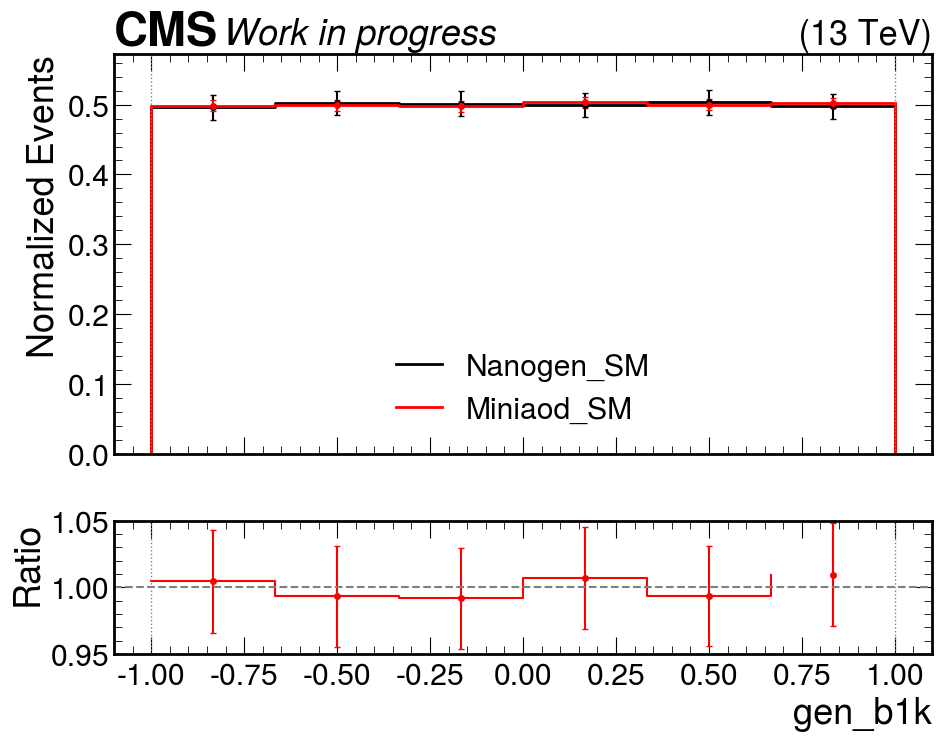

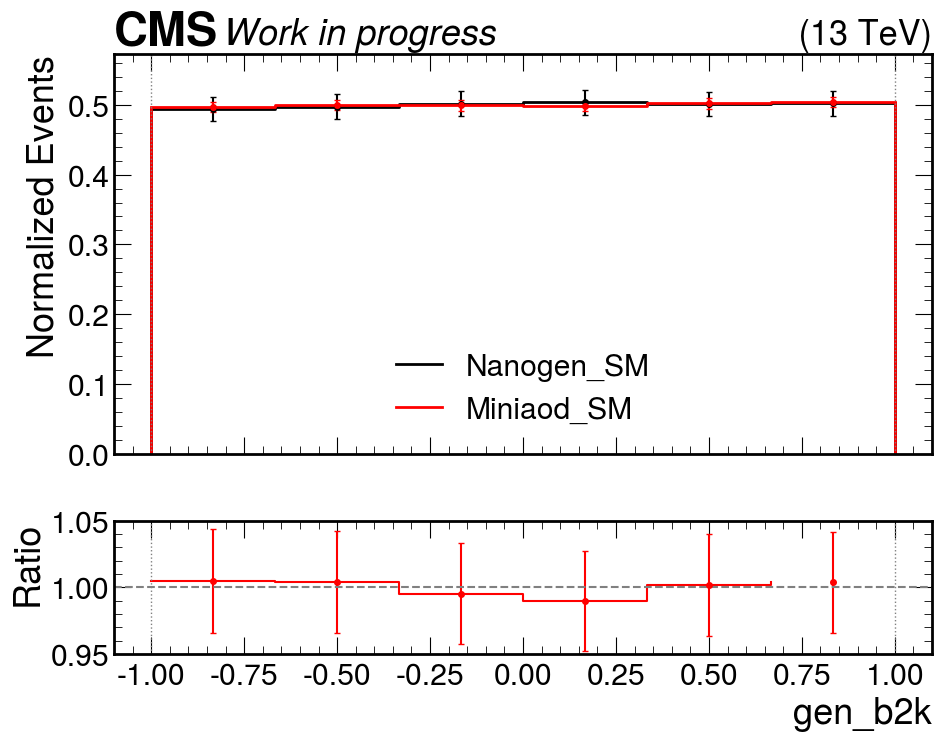

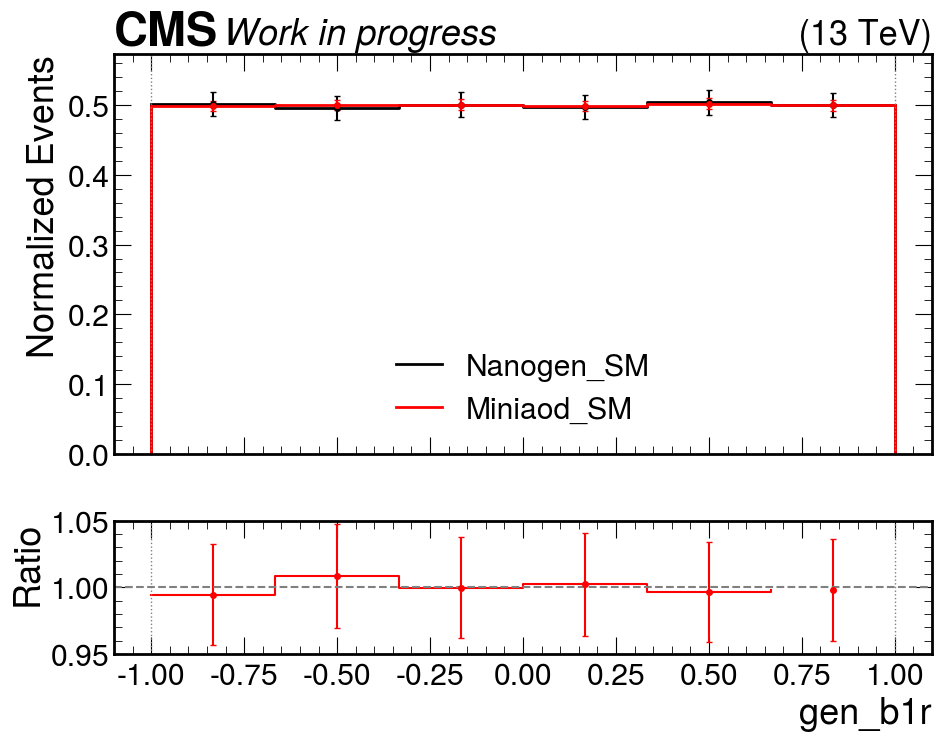

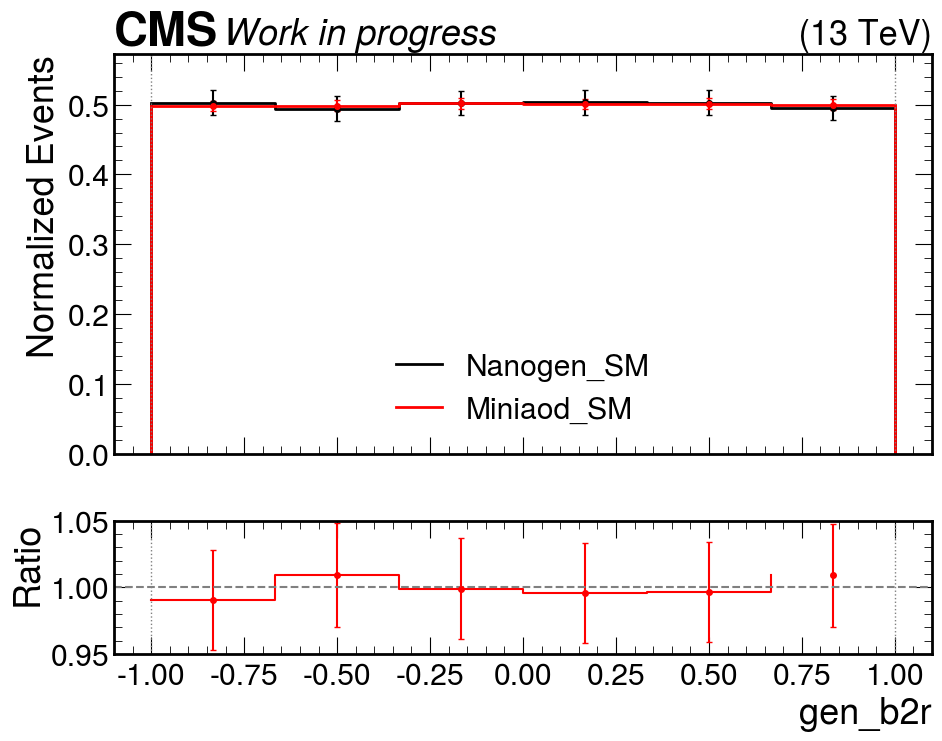

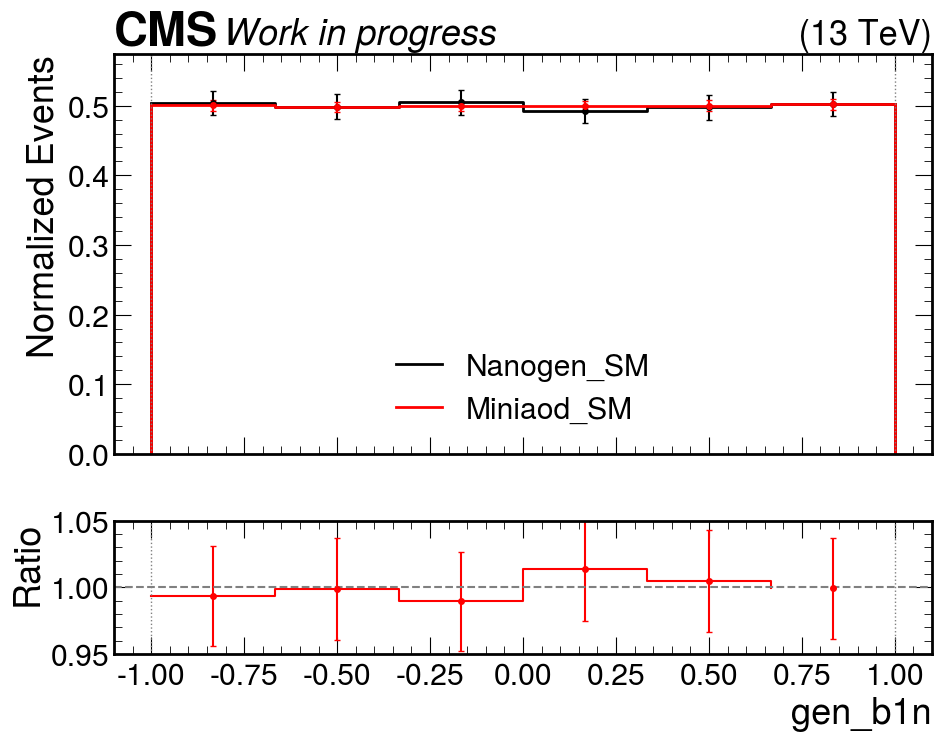

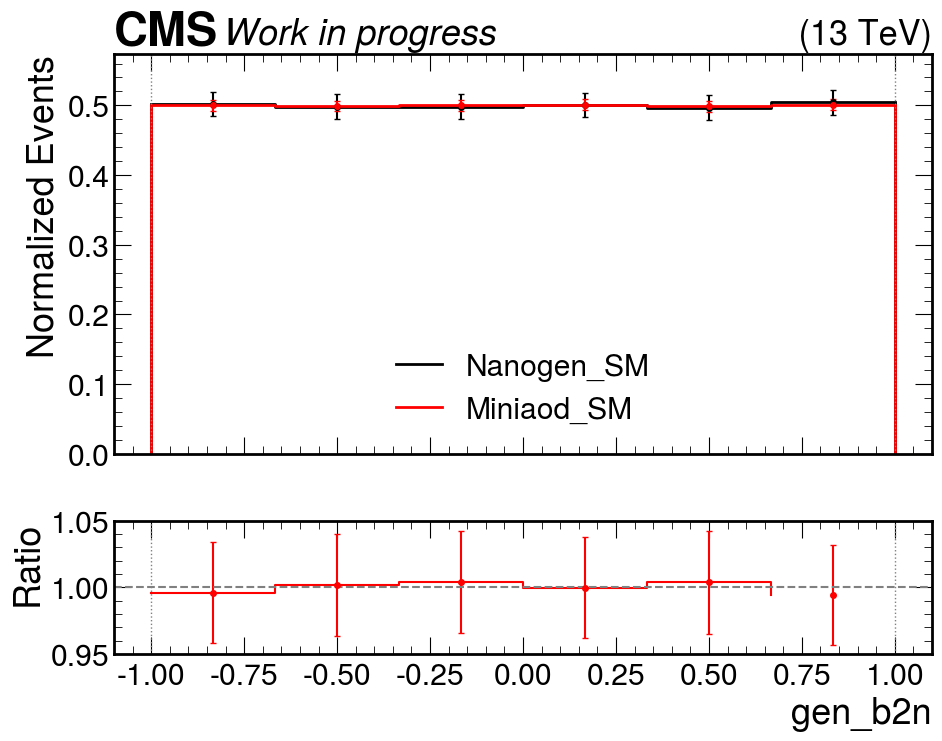

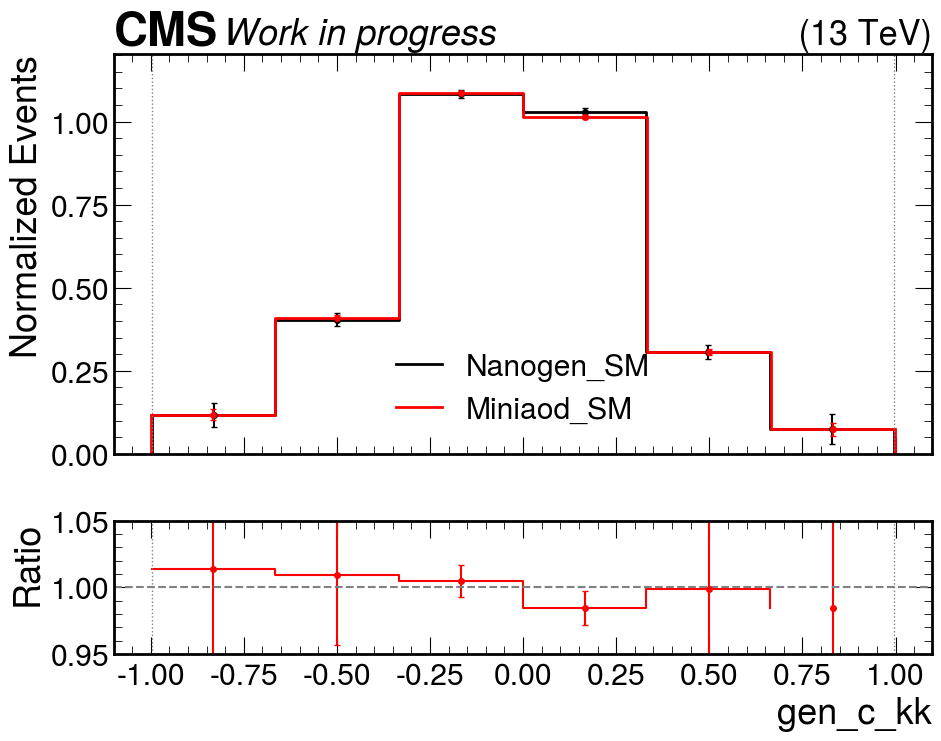

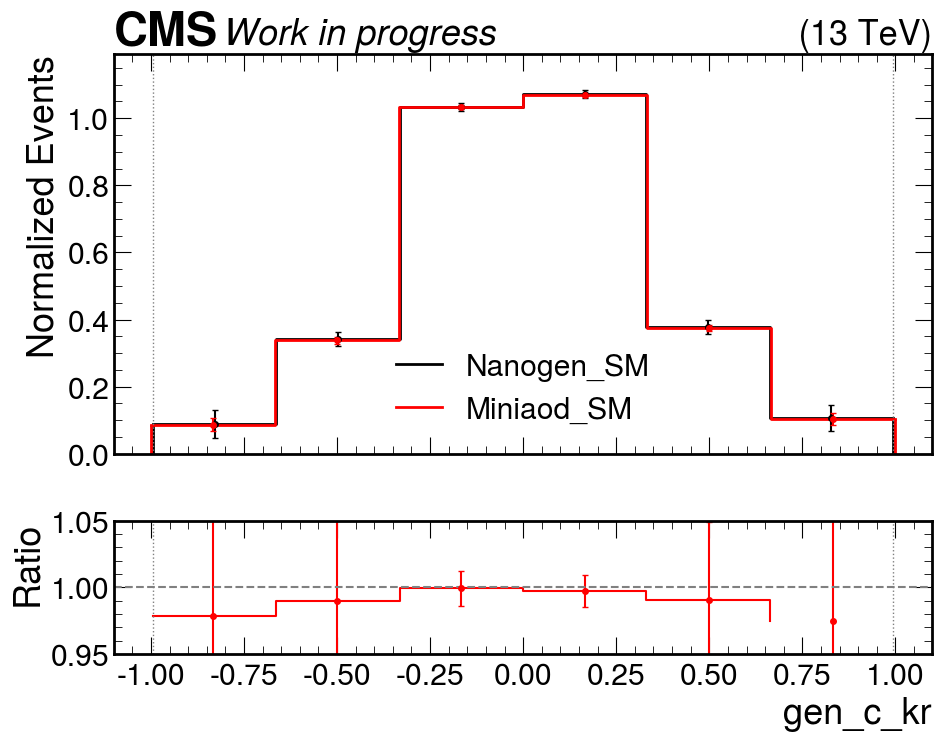

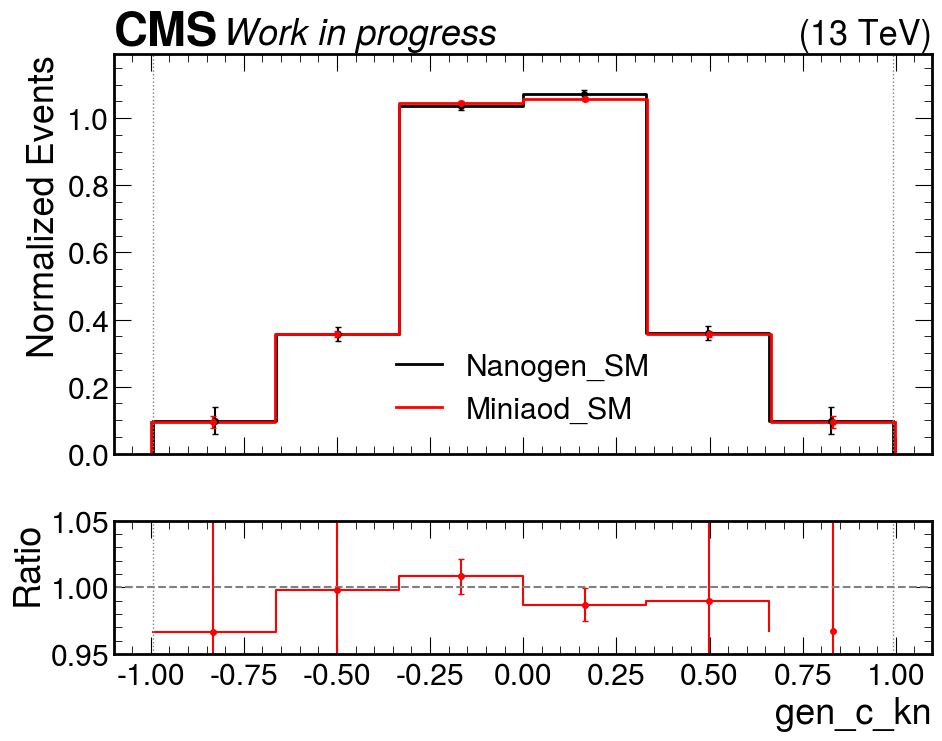

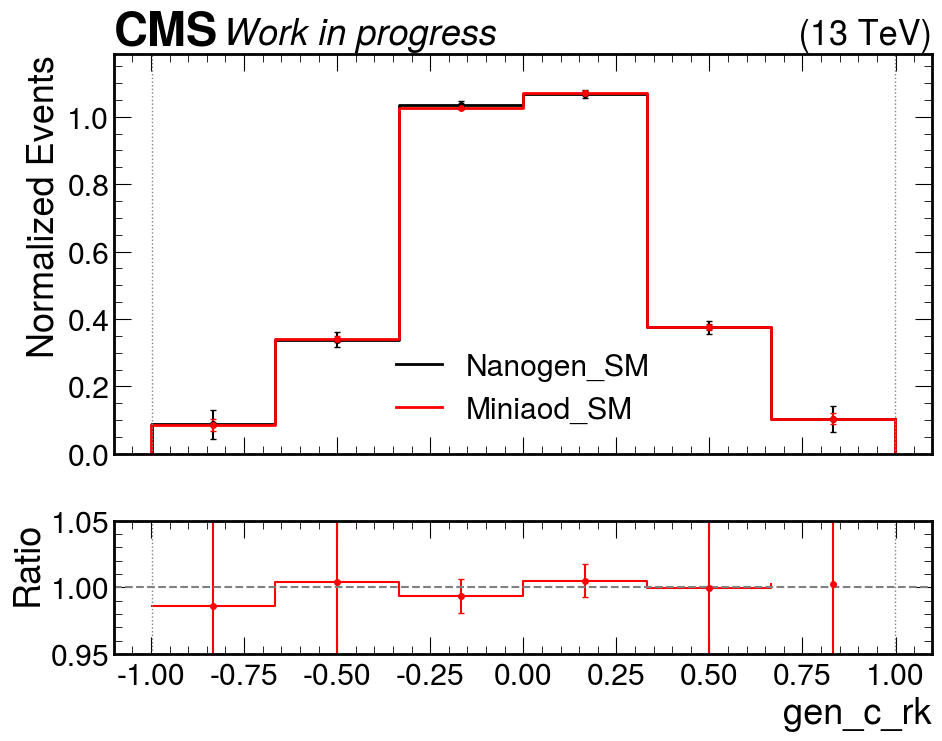

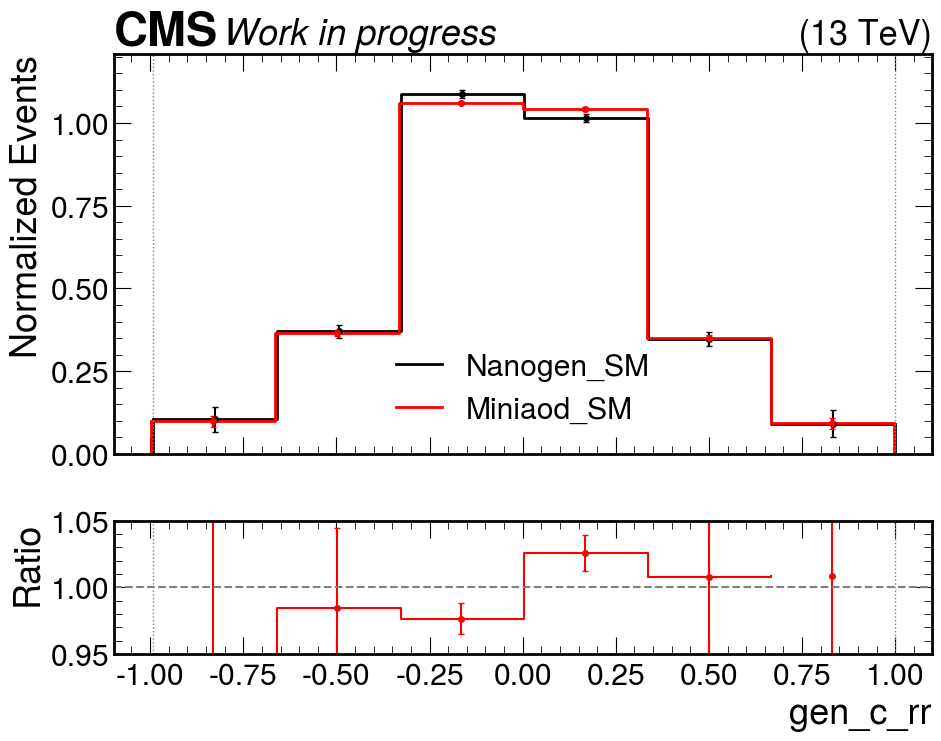

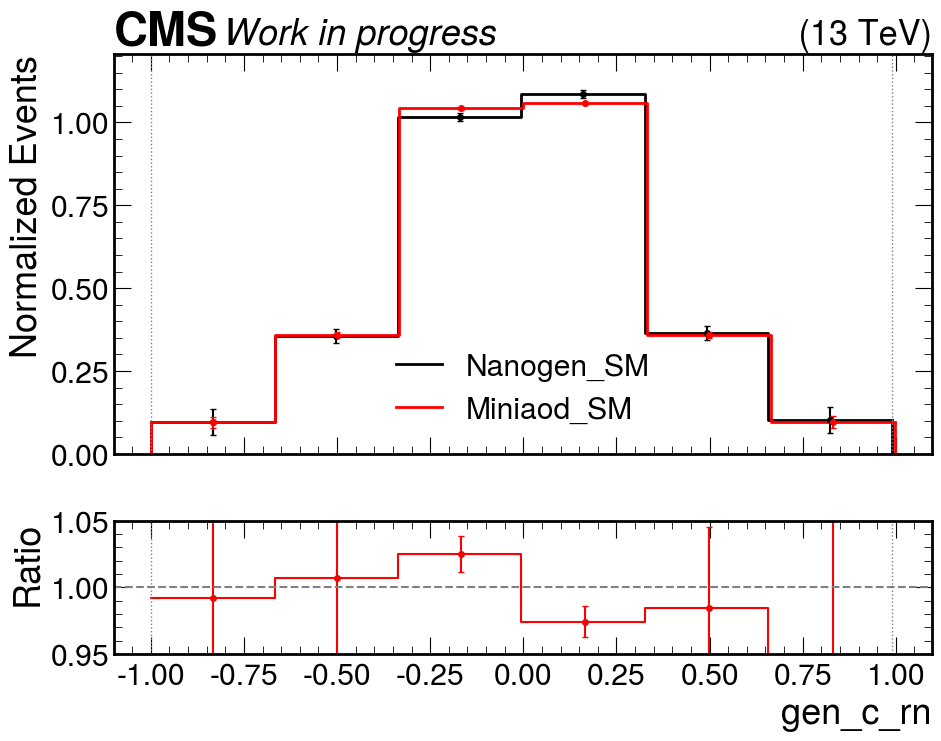

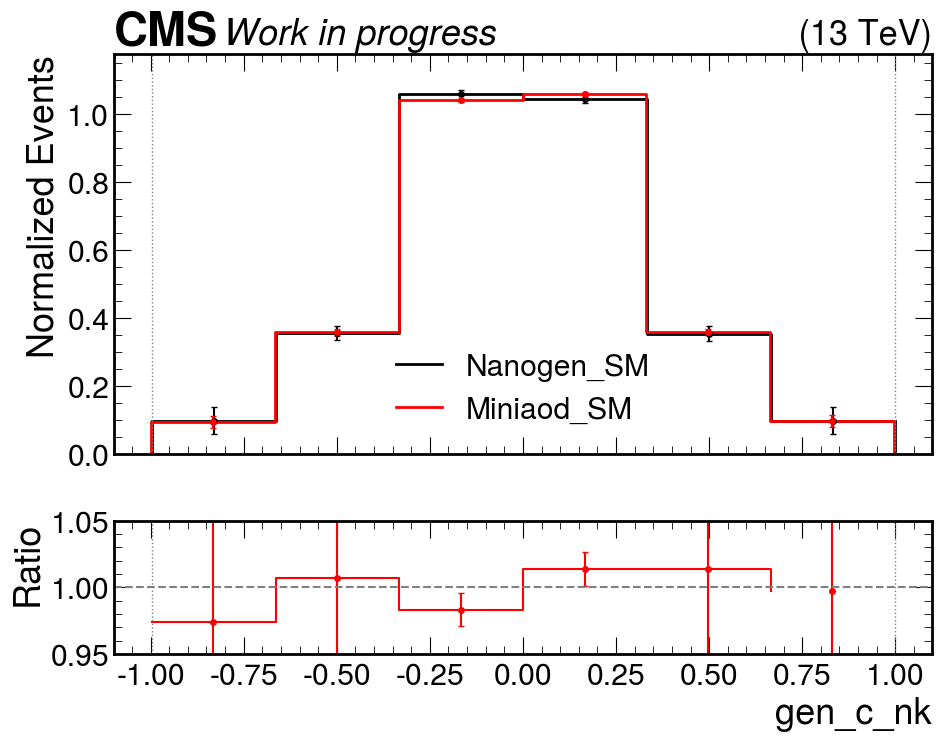

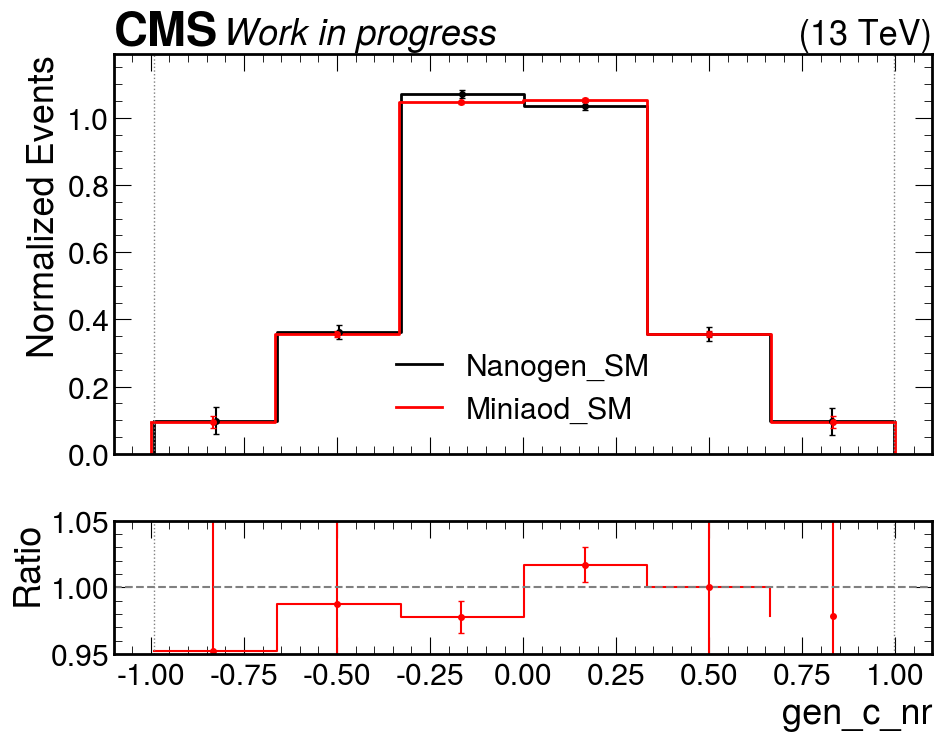

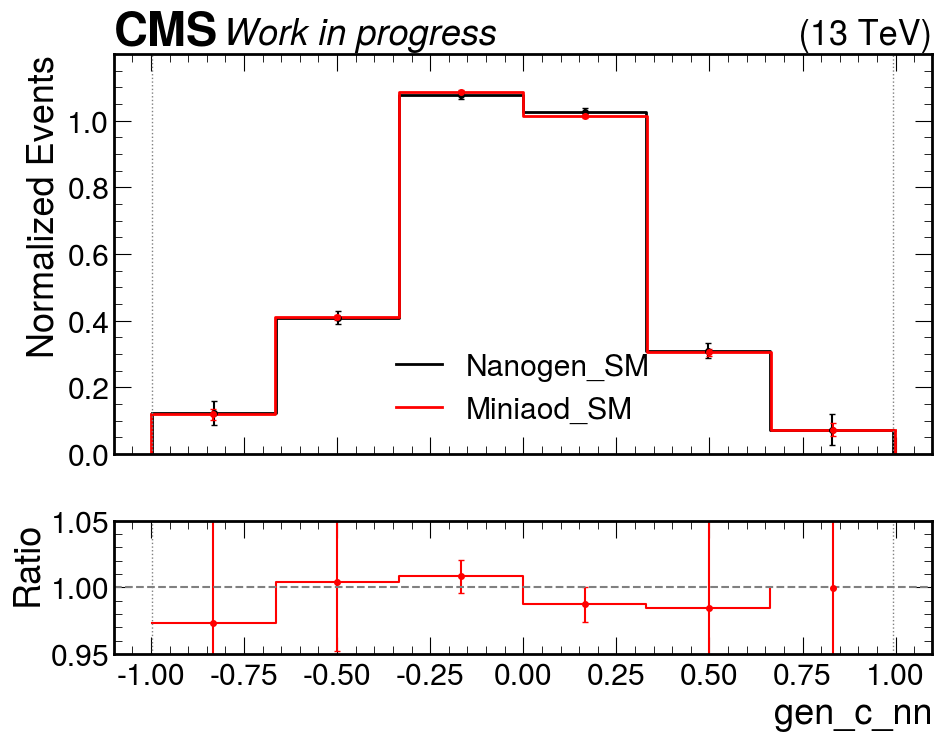

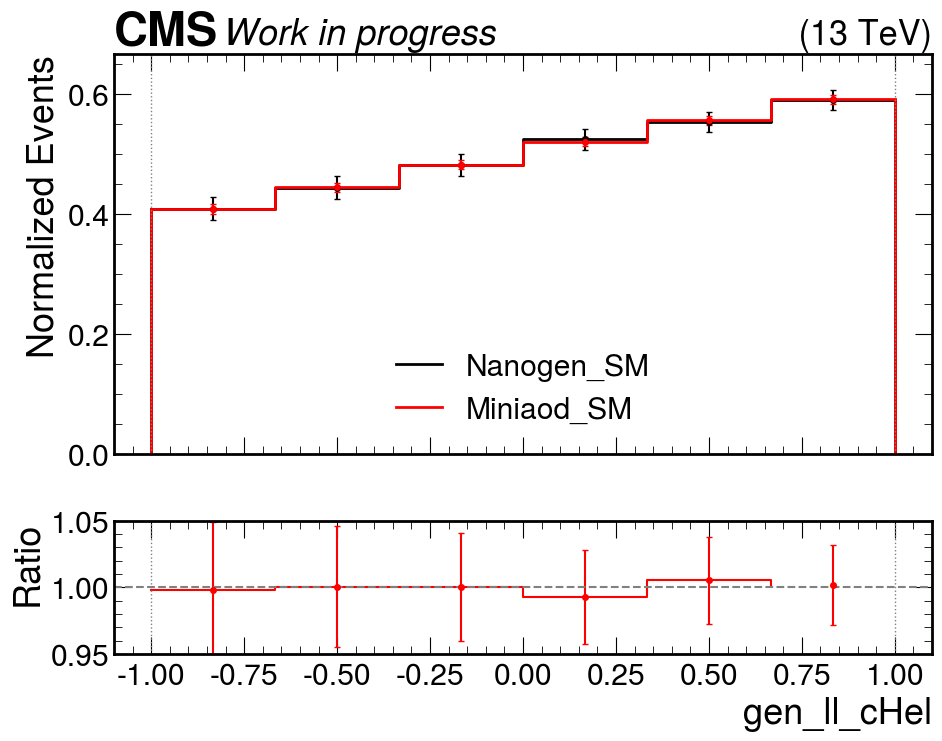

In [40]:
for obs_name in observable_map:
    if obs_name not in observable_powheg:
        print(f" Skipping {obs_name}: not found in POWHEG")
        continue

    # Extract full arrays
    obs_nanogen = observable_map[obs_name]
    obs_powheg = observable_powheg[obs_name]

    # Corresponding weights
    w_nanogen = event_weight  # should match len(obs_nanogen)
    w_powheg = np.ones_like(obs_powheg)  # flat weights

    # Plot
    plot_observables(
        obs_dict={
            "Nanogen_SM": obs_nanogen,
            "Miniaod_SM": obs_powheg
        },
        weights={
            "Nanogen_SM": w_nanogen,
            "Miniaod_SM": w_powheg
        },
        xlabel=obs_name,
        save_name=obs_name
    )
